In [4]:
import torch
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

c:\Users\gsoch\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\gsoch\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [70]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 120)
        self.fc4 = nn.Linear(120, 64)
        self.fc5 = nn.Linear(64, 4)



    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        x = self.fc5(x)

        return x

In [71]:
data = pd.read_csv('D:/Coding/Github/automatic_parking/vision_assisted_autonomous_parking/datasets/dataset_completo.csv')
x = data.iloc[:, :719].values.astype(dtype=np.float32)
y = data.iloc[:, 720].values.astype(dtype=np.int64) 
feature_index = list(range(0,719))
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [72]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

select_k_best = SelectKBest(mutual_info_classif, k=719)
X_train_k_best = select_k_best.fit_transform(X_train_scaled, y_train)
X_test_k_best = select_k_best.transform(X_test_scaled)

selected_features_indices = select_k_best.get_support(indices=True)

np.savetxt('D:/Coding/Github/automatic_parking/vision_assisted_autonomous_parking/Pytorch/k_best_selected_features/selected_features.csv', selected_features_indices, delimiter=',', fmt='%d')

In [73]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

xs_train = torch.tensor(X_train_k_best).view(-1, len(X_train_k_best[0])).to(device)
ys_train = torch.tensor(y_train).to(device)
xs_test = torch.tensor(X_test_k_best).view(-1, len(X_test_k_best[0])).to(device)
ys_test = torch.tensor(y_test).to(device)

In [74]:
mean = torch.mean(xs_train, dim=0)
std_dev = torch.std(xs_train, dim=0)
mean_broadcasted = mean.unsqueeze(0).expand_as(xs_train)
std_dev_broadcasted = std_dev.unsqueeze(0).expand_as(xs_train)
xs_train_z_score = (xs_train - mean_broadcasted) / std_dev_broadcasted
mean_broadcasted = mean.unsqueeze(0).expand_as(xs_test)
std_dev_broadcasted = std_dev.unsqueeze(0).expand_as(xs_test)
xs_test_z_score = (xs_test - mean_broadcasted) / std_dev_broadcasted

In [75]:
max_value = 12          #Ver
min_value = 0

xs_train_min_max = (xs_train - min_value)/(max_value - min_value)
xs_test_min_max = (xs_test - min_value)/(max_value - min_value)

In [76]:
model = NeuralNetwork(len(xs_train_min_max[0]))
model.to(device)

NeuralNetwork(
  (fc1): Linear(in_features=719, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=120, bias=True)
  (fc4): Linear(in_features=120, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=4, bias=True)
)

In [77]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

batch_size = 500
torch.manual_seed(42)
dataset = TensorDataset(xs_train_min_max,ys_train)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [78]:
# Train the model
num_epochs = 5000
loss_per_epoch = []
for epoch in range(num_epochs):
    for batch_idx, (xs_batch, ys_batch) in enumerate(dataloader):
        outputs = model(xs_batch)
        loss = criterion(outputs, ys_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if(epoch % 100 == 0):
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')
        loss_per_epoch.append(loss.item())

print('Training finished.')

Epoch [1/5000], Loss: 1.3959357738494873
Epoch [101/5000], Loss: 0.3122718036174774
Epoch [201/5000], Loss: 0.35536083579063416
Epoch [301/5000], Loss: 0.32277393341064453
Epoch [401/5000], Loss: 0.28875017166137695
Epoch [501/5000], Loss: 0.32883819937705994
Epoch [601/5000], Loss: 0.3345588445663452
Epoch [701/5000], Loss: 0.38724347949028015
Epoch [801/5000], Loss: 0.32834333181381226
Epoch [901/5000], Loss: 0.29929500818252563
Epoch [1001/5000], Loss: 0.372349351644516
Epoch [1101/5000], Loss: 0.3248198330402374
Epoch [1201/5000], Loss: 0.3198944330215454
Epoch [1301/5000], Loss: 0.32893285155296326
Epoch [1401/5000], Loss: 0.3504171371459961
Epoch [1501/5000], Loss: 0.31326958537101746
Epoch [1601/5000], Loss: 0.32078808546066284
Epoch [1701/5000], Loss: 0.3247743844985962
Epoch [1801/5000], Loss: 0.29374319314956665
Epoch [1901/5000], Loss: 0.2640950679779053
Epoch [2001/5000], Loss: 0.35220107436180115
Epoch [2101/5000], Loss: 0.2798774838447571
Epoch [2201/5000], Loss: 0.331591

In [79]:
with torch.no_grad():
    outputs = model(xs_test_min_max)
# Metrics calculation (optional)
_, predicted = torch.max(outputs, 1)
accuracy = (predicted == ys_test).sum().item() / ys_test.size(0)
# Calculate other metrics as needed

print(f"Loss: {loss.item()}")
print(f"Accuracy: {accuracy}")

Loss: 0.3197258710861206
Accuracy: 0.5481927710843374


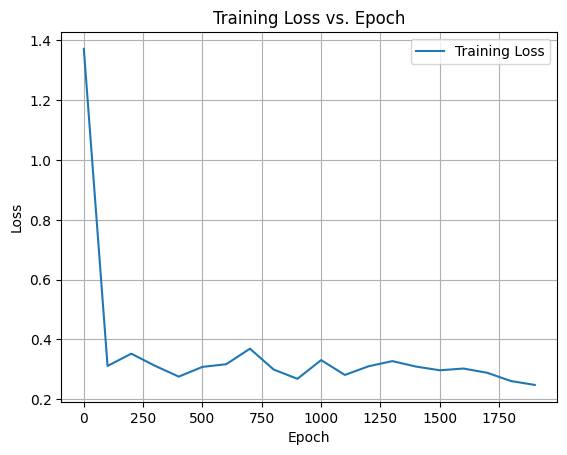

In [46]:
plt.plot(range(0,2000,100), loss_per_epoch, label='Training Loss')
plt.title('Training Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

In [28]:
model.eval()
with torch.no_grad():
    predicted_value = model(torch.tensor(xs_test_min_max[3]).to(device))
print("Input Feature: " + str(xs_test_min_max[3]))
print("Expected Value: " + str(ys_test[3]))
print("Model Output: " + str(predicted_value))
print("Model Prediction: " + str(torch.argmax(predicted_value)))

Input Feature: tensor([-0.0526, -0.0584, -0.0561, -0.0421, -0.0412, -0.0356, -0.0430, -0.0466,
        -0.0519, -0.0546, -0.0547, -0.0538, -0.0574, -0.0593, -0.0586, -0.0592,
        -0.0666, -0.0679, -0.0635, -0.0617, -0.0585, -0.0600, -0.0546, -0.0647,
        -0.0656, -0.0635, -0.0634, -0.0714, -0.0714, -0.0714, -0.0723, -0.0813,
        -0.0698, -0.0799, -0.0785, -0.0957, -0.0932, -0.0801, -0.0546,  0.0619,
         0.0581,  0.0573,  0.0574,  0.0568,  0.0577,  0.0576,  0.0575,  0.0544,
         0.0543,  0.0615,  0.0629,  0.0601,  0.0559,  0.0546,  0.0492,  0.0456,
         0.0461,  0.0468,  0.0469,  0.0475,  0.0467,  0.0479,  0.0489,  0.0483,
         0.0442,  0.0411,  0.0414,  0.0432,  0.0444,  0.0454,  0.0451,  0.0481,
         0.0478,  0.0488,  0.0515,  0.0542,  0.0581,  0.0587,  0.0600,  0.0035,
         0.0067,  0.0019, -0.0083, -0.0092, -0.0146, -0.0197, -0.0230, -0.0305,
        -0.0352, -0.0372, -0.0455, -0.0539, -0.0559, -0.0549, -0.0546, -0.0576,
        -0.0623, -0.0604,

C:\Users\gsoch\AppData\Local\Temp\ipykernel_6960\3084701899.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicted_value = model(torch.tensor(xs_test_min_max[0]).to(device))


In [30]:
torch.save(model.state_dict(), 'D:/Coding/Github/automatic_parking/vision_assisted_autonomous_parking/Pytorch/model/model_final.pth')

In [21]:
model = NeuralNetwork(len(xs_train_z_score[0]))
model.load_state_dict(torch.load('datasets/model1.pth'))
model.eval()

NeuralNetwork(
  (fc1): Linear(in_features=10, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=3, bias=True)
)

In [24]:
with torch.no_grad():
    predicted_value = model(torch.tensor(xs_test[400]).to(device))
print("Input Feature: " + str(xs_test[400]))
print("Expected Value: " + str(ys_test[400]))
print("Model Prediction: " + str(torch.argmax(predicted_value)))

Input Feature: tensor([-1.0493, -1.2094, -1.3192, -1.3859, -1.0902, -1.0788, -1.5170, -1.0826,
        -1.0960, -0.9731])
Expected Value: tensor(1)
Model Prediction: tensor(1)


C:\Users\gsoch\AppData\Local\Temp\ipykernel_7860\1364314063.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicted_value = model(torch.tensor(xs_test[400]).to(device))


AlexNET 1D for Lidar Applications

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AlexNet(nn.Module):
    def __init__(self, num_classes=4):
        super(AlexNet, self).__init__()
        self.conv1 = nn.Conv1d(stride=2,in_channels=1,kernel_size=32)
        self.conv2 = nn.Conv1d(in_channels=1,kernel_size=120, stride=1, padding=2)
        self.conv3 = nn.Conv1d(in_channels=1,kernel_size=20, stride=1,padding=1)
        self.conv4 = nn.Conv1d(in_channels=1,kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv1d(in_channels=1,kernel_size=256, stride=1, padding=1)
        self.fc1 = nn.Linear(4096, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool1d(self.conv1(x),stride=2,kernel_size=1)
        print(x.shape)
        x = F.max_pool1d(self.conv2(x),stride=2,kernel_size=1)
        print(x.shape)
        x = F.relu(self.conv3(x))
        print(x.shape)
        x = F.relu(self.conv4(x))
        print(x.shape)
        x = F.max_pool1d(self.conv5(x),stride=2,kernel_size=1)
        print(x.shape)
        x = F.relu(self.fc1(x))
        print(x.shape)
        x = F.relu(self.fc2(x))
        print(x.shape)
        x = self.fc3(x)
        return F.log_softmax(x, -1)



In [5]:
data = pd.read_csv('D:/Coding/Github/automatic_parking/vision_assisted_autonomous_parking/datasets/dataset_completo.csv')
x = data.iloc[:, :719].values.astype(dtype=np.float32)
y = data.iloc[:, 720].values.astype(dtype=np.int64) 
feature_index = list(range(0,719))
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("You are using", device)

xs_train = torch.tensor(X_train).view(-1, len(X_train[0])).to(device)
ys_train = torch.tensor(y_train).to(device)
xs_test = torch.tensor(X_test).view(-1, len(X_test)).to(device)
ys_test = torch.tensor(y_test).to(device)

You are using cpu


In [7]:
max_value = 12        
min_value = 0

xs_train_min_max = (xs_train - min_value)/(max_value - min_value)
xs_test_min_max = (xs_test - min_value)/(max_value - min_value)

In [8]:

dataset = TensorDataset(xs_train.unsqueeze(1), ys_train)
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize the model, loss function, and optimizer
model = AlexNet(num_classes=4)  # Adjust based on your model and dataset
model.to(device)
criterion = nn.NLLLoss()  # Negative log likelihood loss since we used log_softmax in the model
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with learning rate 0.001


TypeError: Conv1d.__init__() missing 1 required positional argument: 'out_channels'

In [63]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(dataloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if i % 10 == 9:  # Print every 10 mini-batches
            print('[%d, %5d] loss: %.3f accuracy: %.2f %%' %
                  (epoch + 1, i + 1, running_loss / 10, 100 * correct / total))
            running_loss = 0.0

print('Finished Training')

torch.Size([32, 1, 150])
torch.Size([32, 1, 18])
torch.Size([32, 1, 1])
torch.Size([32, 1, 1])
torch.Size([32, 1, 1])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x1 and 4096x4096)